# 1. Importar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels

# 2. Importar set de entrenamiento

In [2]:
data_train = pd.read_json('train.json')
data_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
data_train['ingr_data'] = data_train['ingredients'].apply(lambda x: " ".join(x).lower())
data_train.head()

,cuisine,id,ingredients,ingr_data
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


Por ser pocos datos, tomo como un filtro de outliers el sacar los que tengan más de 6 palabras.

In [4]:
data_train.shape

(39774, 4)

In [5]:
X = data_train['ingr_data']
#target = data_train['cuisine']
y = data_train['cuisine']

In [6]:
# label = LabelEncoder()
# y = label.fit_transform(target)

In [7]:
#label.classes_

In [8]:
pd.Series(y).unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

# Balancear las clases

Hacerlo con 'class_weight' 

# 3. Split en Train y Test

Para armar y validar el modelo dividimos los datos del archivo 'train.json' en train y test. Luego de haber probado y elegido el mejor modelo posible, se realizarán predicciones sobre un nuevo set de datos del archivo 'test.json', del cual no se conocen las etiquetas.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [10]:
X.shape,y.shape

((39774,), (39774,))

In [11]:
X_train.shape,y_train.shape

((29830,), (29830,))

In [13]:
X_test.shape,y_test.shape

((9944,), (9944,))

In [14]:
vec = CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                      encoding='utf-8',lowercase=True, max_df=1.0,
                      max_features=5000, min_df=1,ngram_range=(1, 1), stop_words='english',
                      strip_accents=None, token_pattern='(?u)\\b\\w\\w\\w+\\b')

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

In [15]:
# #vec = CountVectorizer(stop_words='english')
# vec = CountVectorizer(binary=True,lowercase=True)
# X_train = vec.fit_transform(X_train)
# X_test = vec.transform(X_test)

In [16]:
# modelo_tfidf = TfidfVectorizer(binary=True)
# X_train = modelo_tfidf.fit_transform(X_train)
# X_test = modelo_tfidf.transform(X_test)

In [17]:
X_train.shape,y_train.shape


((29830, 2821), (29830,))

In [18]:
feat_selector = SelectPercentile(f_classif, percentile=10)
feat_selector = feat_selector.fit(X_train,y_train)

X_train_new = feat_selector.transform(X_train)
X_train_new.shape

(29830, 282)

In [19]:
X_test.shape,y_test.shape


((9944, 2821), (9944,))

In [20]:
X_test_new = feat_selector.transform(X_test)
X_test_new.shape

(9944, 282)

# 4. Instanciando el modelo

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [22]:
# SVC.get_params(SVC).keys()

In [23]:
pipeline = Pipeline([
    ('vect', CountVectorizer()), 
    ('ftr', SelectPercentile()),
    ('clf', SVC()), 
   ])

In [24]:
parameters = {
    'vect__max_features': [5000,10000],
    'vect__ngram_range': [(1, 1),(1,2)],
    'vect__stop_words': ['english'],
    'vect__binary': [True],
    'vect__token_pattern' : [r'(?u)\b\w\w\w+\b'],
    'ftr__percentile':[10],
    'ftr__score_func':[f_classif],
    'clf__C':[10,100],
    'clf__gamma':[0.1,1],
    'clf__kernel':['rbf'],
    'clf__class_weight':['balanced'],
    'clf__probability':[False],
    'clf__max_iter':[50000]
}

In [25]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1 , verbose = 2 , cv=3)

In [26]:
print("Performing grid search...") 
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Performing grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 49.7min finished


Best score: 0.739
Best parameters set:
	 clf__C: 10
	 clf__class_weight: 'balanced'
	 clf__gamma: 0.1
	 clf__kernel: 'rbf'
	 clf__max_iter: 50000
	 clf__probability: False
	 ftr__percentile: 10
	 ftr__score_func: <function f_classif at 0x0000017F9E7A4D90>
	 vect__binary: True
	 vect__max_features: 10000
	 vect__ngram_range: (1, 2)
	 vect__stop_words: 'english'
	 vect__token_pattern: '(?u)\\b\\w\\w\\w+\\b'


In [11]:
pipe_best1 = Pipeline([
    ('vect', CountVectorizer(binary = grid_search.best_params_['vect__binary'],
                            max_features = grid_search.best_params_['vect__max_features'],
                            ngram_range = grid_search.best_params_['vect__ngram_range'],
                            stop_words = 'english',
                            token_pattern = '(?u)\\b\\w\\w\\w+\\b')), 
    ('ftr', SelectPercentile(percentile = grid_search.best_params_['ftr__percentile'],
                            score_func = grid_search.best_params_['ftr__score_func'])),
    ('clf', SVC(C = grid_search.best_params_['clf__C'],
               class_weight = 'balanced',
               gamma = grid_search.best_params_['clf__gamma'],
               kernel = 'rbf',
               max_iter = 50000)), 
   ])

NameError: name 'grid_search' is not defined

In [ ]:
pipe_best1.fit(X_train,y_train)

In [ ]:
y_pred = pipe_best1.predict(X_test)
y_pred_train = pipe_best1.predict(X_train)
print("Accuracy sobre Train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred)))

In [ ]:
plt.figure(figsize=(15, 15))
classes = unique_labels(y_test, y_pred)

# #tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, labels= classes, rotation=90)
# plt.yticks(tick_marks, labels= classes, rotation=-45)
plt.title("confusion matrix")

mat = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);
plt.savefig('Images/Con_Mat_SVM.png')

In [ ]:
print(classification_report(y_test, y_pred))

In [7]:
pipe_best = Pipeline(steps=[
    ('vect', CountVectorizer(binary=True,max_features=5000,ngram_range=(1,1),
                             stop_words='english',token_pattern='(?u)\\b\\w\\w\\w+\\b')),
    ('ftr', SelectPercentile(score_func = f_classif,percentile=20)),
    ('clf', SVC(C=10,class_weight='balanced',gamma=0.1,kernel='rbf',
               max_iter=50000,probability=False)), 
     ],verbose=True)

In [8]:
pipe_best.fit(X_train,y_train)
pred=pipe_best.predict(X_test)

y_pred_train = pipe_best.predict(X_train)
print("Accuracy sobre Train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy sobre Test: {}".format(accuracy_score(y_test, pred)))

[Pipeline] .............. (step 1 of 3) Processing vect, total=   0.8s
[Pipeline] ............... (step 2 of 3) Processing ftr, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing clf, total= 2.4min
Accuracy sobre Train: 0.9897083473013745
Accuracy sobre Test: 0.7774537409493162


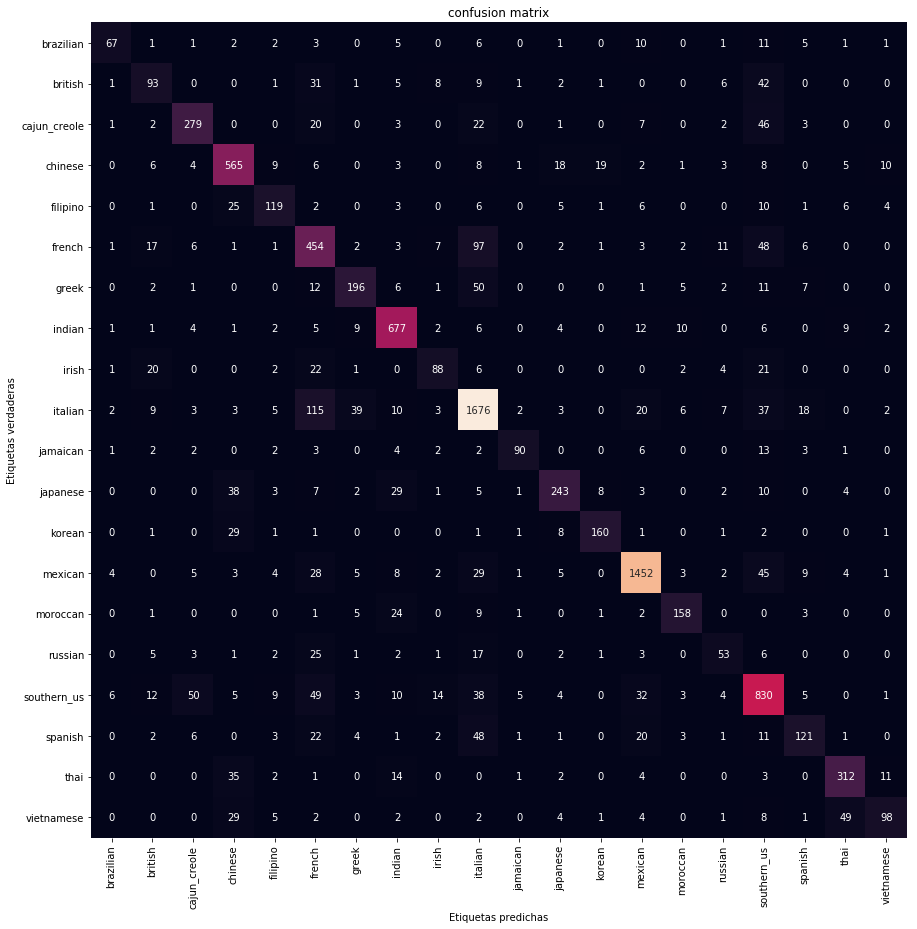

In [9]:
plt.figure(figsize=(15, 15))
classes = unique_labels(y_test, pred)

# #tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, labels= classes, rotation=90)
# plt.yticks(tick_marks, labels= classes, rotation=-45)
plt.title("confusion matrix")

mat = confusion_matrix(y_test, pred)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);
plt.savefig('Images/Con_Mat_SVM.png')

In [10]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   brazilian       0.79      0.57      0.66       117
     british       0.53      0.46      0.49       201
cajun_creole       0.77      0.72      0.74       386
     chinese       0.77      0.85      0.80       668
    filipino       0.69      0.63      0.66       189
      french       0.56      0.69      0.62       662
       greek       0.73      0.67      0.70       294
      indian       0.84      0.90      0.87       751
       irish       0.67      0.53      0.59       167
     italian       0.82      0.86      0.84      1960
    jamaican       0.86      0.69      0.76       131
    japanese       0.80      0.68      0.74       356
      korean       0.83      0.77      0.80       207
     mexican       0.91      0.90      0.91      1610
    moroccan       0.82      0.77      0.79       205
     russian       0.53      0.43      0.48       122
 southern_us       0.71      0.77      0.74      1080
     spanish       0.66    

In [ ]:
grid_search.best_estimator_.fit(X_train,y_train)
y_pred=grid_search1.best_estimator_.predict(X_test)

print("Accuracy sobre Test: {}".format(accuracy_score(y_test, y_pred)))

In [ ]:
# LinearSVC.get_params(LinearSVC).keys()

In [ ]:
#from sklearn.preprocessing import MaxAbsScaler

#scaler = MaxAbsScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
# #parameters = {'C':(0.1,1,10,100),'multi_class':('ovr','crammer_singer')}
# #clf = GridSearchCV(estimator=lin_svc, param_grid=parameters,cv=kf)
# #print("accuracy:"+str(np.average(cross_val_score(clf, X_train, Y, scoring='accuracy'))))
# #print("f1:"+str(np.average(cross_val_score(clf, X_train, Y, scoring='f1'))))

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=10)

# model_SVC = SVC()
# param_grid = {'C':[10,100],'gamma':[0.1,1],'max_iter':[100000],'kernel':['rbf']}
# grid_search = GridSearchCV(estimator=model_SVC, param_grid=param_grid,cv=kf,verbose=2,n_jobs=2)


In [ ]:
# grid_search.fit(X_train_new,y_train)

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
# svc = SVC()
# parameters = {'C':[10,100],'gamma':[0.1,1],'decision_function_shape':['ovr']}
# grid_search = GridSearchCV(estimator=svc,param_grid=parameters,cv=kf)
# grid_search.fit(X_train,y_train)

In [ ]:

# lin_svc = LinearSVC(max_iter=10000,multi_class='ovr',C=100)
# lin_svc.fit(X_train,y_train)
# y_pred = lin_svc.predict(X_test)
# accuracy_score(y_test,y_pred)


In [ ]:
# model_SVC = SVC(C=100, # penalty parameter
#                 kernel='rbf', # kernel type, rbf working fine here
#                 degree=3, # default value
#                 gamma=1, # kernel coefficient
#                 coef0=1, # change to 1 from default value of 0.0
#                 shrinking=True, # using shrinking heuristics
#                 tol=0.001, # stopping criterion tolerance 
#                 probability=False, # no need to enable probability estimates
#                 cache_size=200, # 200 MB cache size
#                 class_weight=None, # all classes are treated equally 
#                 verbose=False, # print the logs 
#                 max_iter=-1, # no limit, let it run
#                 decision_function_shape=None, # will use one vs rest explicitly 
#                 random_state=None)

In [ ]:
# model_SVC.fit(X_train,y_train)

In [ ]:
# y_pred = model_SVC.predict(X_test)
# accuracy_score(y_test,y_pred)